In [1]:
import torch
x,y=torch.load('tractor9train')
x1,y1=torch.load('tractor9valid')
x2,y2=torch.load('tractor9test')

print(f'train:{len(y)-sum(y)}<->{sum(y)}   valid:{len(y1)-sum(y1)}<->{sum(y1)}  test:{len(y2)-sum(y2)}<->{sum(y2)}')

train:107284<->620914   valid:24418<->177915  test:37948<->69208


In [2]:
import torch
import torchvision
import os
import sys
Xtrain,ytrain=torch.load('tractor9train')
Xtest,ytest=torch.load('tractor9valid')
types={0:'road',1:'field'}

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
#可视化图像


#MLP-mixer
import torch
from torch import nn
SIZE=5
P=1
CHANNELS=192
PATCHES=int((SIZE/P)**2)
#可调隐藏宽度DS DC
DS=96
DC=768

class TokenMixer(nn.Module):
    def __init__(self):
        global PATCHES,DS,CHANNELS
        super().__init__()
        self.tokenblock=nn.Sequential(
            nn.Linear(PATCHES,DS),
            nn.BatchNorm1d(CHANNELS),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(DS,PATCHES),
            )
            
    def forward(self,x):
        return self.tokenblock(x)
    
class ChannelMixer(nn.Module):
    def __init__(self):
        global CHANNELS,DC,PATCHES
        super().__init__()
        self.channelblock=nn.Sequential(
            nn.Linear(CHANNELS,DC),
            nn.BatchNorm1d(PATCHES),
            nn.GELU(),
            nn.Dropout(),
            nn.Linear(DC,CHANNELS),
            )
        
    def forward(self,x):
        return self.channelblock(x)
class MixerLayer(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_mixing=TokenMixer()
        self.channel_mixing=ChannelMixer()
        
    def forward(self,x):#patches*channels
        global CHANNELS
        y=nn.LayerNorm(CHANNELS)(x)
        y=torch.permute(y,(0,2,1))
        y=self.token_mixing(y)
        y=torch.permute(y,(0,2,1))
        x=x+y
        y=nn.LayerNorm(CHANNELS)(x)
        y=self.channel_mixing(y)
        return x+y
from typing import OrderedDict
class Mixer(nn.Module):
    def __init__(self,num):
        global CHANNELS,PATCHES,P
        super().__init__()
        self.patch_connect=nn.Conv2d(9, CHANNELS, P,stride=P)
        blocks=OrderedDict()
        for i in range(num):
            blocks['MixerLayer '+str(i)]=MixerLayer()
        self.mixerblocks=nn.Sequential(blocks)
        self.full_connect=nn.Linear(PATCHES,2)
        
    def forward(self,x):
        global CHANNELS,PATCHES
        y=nn.BatchNorm2d(9)
        y=self.patch_connect(x)
        y=nn.Flatten(start_dim=2)(y)#channels*patches
        y=torch.permute(y, (0,2,1))
        y=self.mixerblocks(y)
        y=nn.LayerNorm(CHANNELS)(y)
        #全局最大池化
        y=nn.MaxPool1d(CHANNELS)(y)
        y=nn.Flatten()(y)
        y=self.full_connect(y)
        return y
    

In [4]:
#数据预加载
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import Compose,ToTensor,Lambda,Normalize,Resize
class Mydata(Dataset):
    def __init__(self,X,y):
        self.X=X
        self.target_transform=Lambda(lambd=lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, y.clone().detach(), value=1))
        self.y=y
    def __len__(self):
        return len(self.y)
    def __getitem__(self,idx):
        data=torch.reshape(self.X[idx],(5,5,9))
        data=torch.permute(data,(2,0,1))
        label=self.target_transform(self.y[idx])
        return data.float(),label.float()
    

In [5]:
traindata=Mydata(Xtrain,ytrain)
testdata=Mydata(Xtest,ytest)

trainloader=DataLoader(traindata,batch_size=2048,shuffle=True)
testloader=DataLoader(testdata,batch_size=2048,shuffle=False)

# Warmup 6steps


epoch 1 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

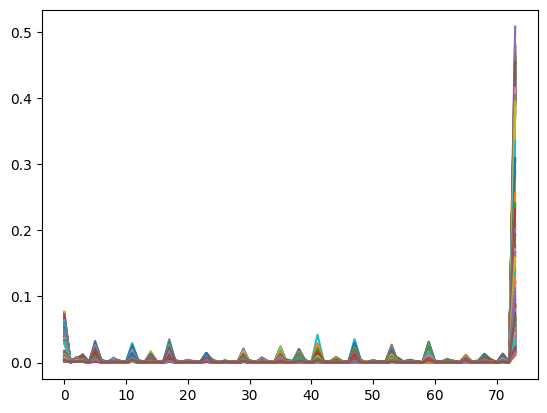


train loss:0.7026957869111152
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.6187423702510219

epoch 2 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

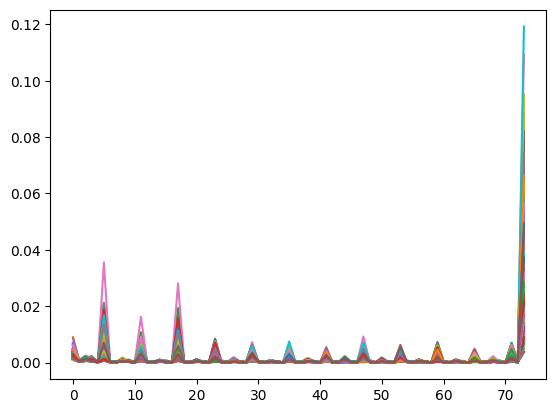


train loss:0.18479747877696925
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.9161431896922401

epoch 3 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

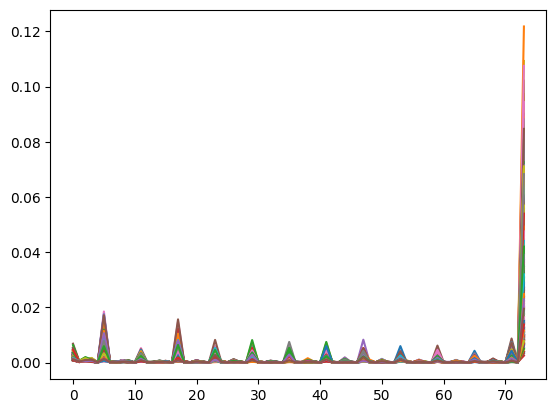


train loss:0.1387560157670399
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.9441761848042584

epoch 4 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

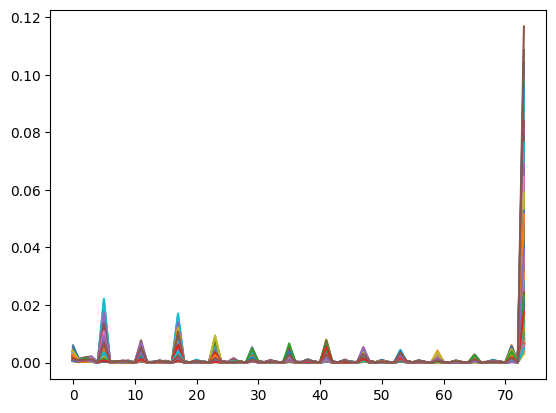


train loss:0.11966550523896566
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.9572684633747337

epoch 5 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

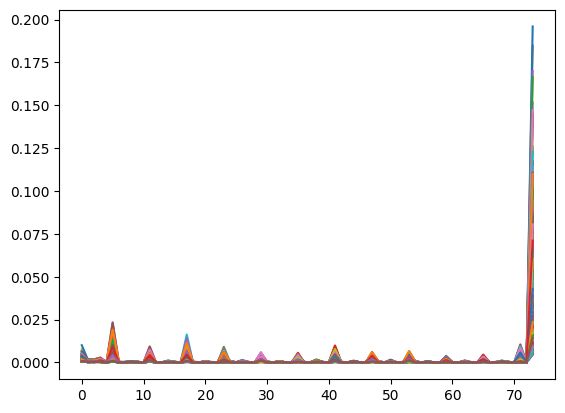


train loss:0.11010825703067056
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.963673745755759

epoch 6 start
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

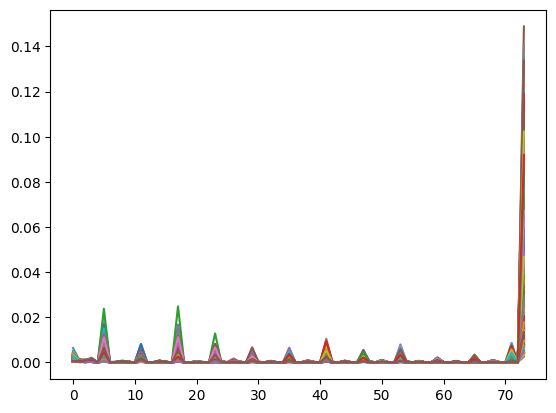


train loss:0.10264348345442434
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.9629472206708742

epoch 7 start
>>>>>>>>>>

KeyboardInterrupt: 

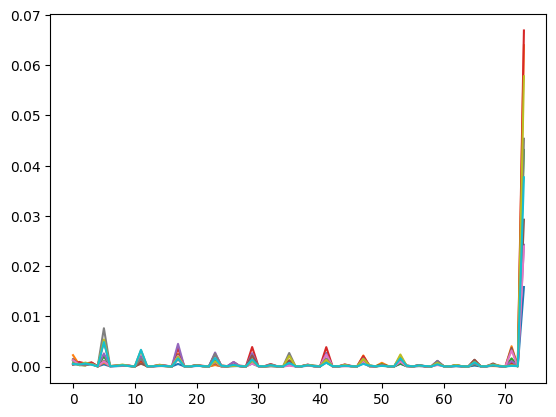

In [6]:
from torch.nn import CrossEntropyLoss,init
from torch.optim import Adam,SGD,lr_scheduler
from torch.nn.utils import clip_grad_norm_

mixer=Mixer(12).to('cuda')

# 自定义初始化
for name,params in mixer.named_parameters():
    init.normal_(params)

loss_fn=CrossEntropyLoss()#Softmax included
#warmup
optimizer=Adam(mixer.parameters(),lr=0.1)
epoches=100
scheduler=lr_scheduler.LinearLR(optimizer,start_factor=1e-4,end_factor=1,total_iters=epoches*len(trainloader))
losslist=[]
for i in range(epoches):
    print(f'\nepoch {i+1} start')
    avgloss=0
    mixer.train()
    for idx,(X,y) in enumerate(trainloader):
        with torch.device('cuda'):
            torch.cuda.empty_cache()
            pred=mixer(X.to('cuda'))
            loss=loss_fn(pred,y.to('cuda'))
            loss.backward()
            biasmaxlist=[]
            weightmaxlist=[]
            for name,params in mixer.named_parameters():
                if 'bias' in name:
                    biasmaxlist.append(params.grad.max().item())
                else:
                    weightmaxlist.append(params.grad.max().item())
            clip_grad_norm_(mixer.parameters(), max_norm=0.5,norm_type=1)#gradient-clipping  if ratio>1,then scale return total_norm
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            avgloss+=loss.item()
            print(end='>')
            plt.plot(weightmaxlist)
    plt.show()
    avgloss=avgloss/(idx+1)
    print(f'\ntrain loss:{avgloss}')
    losslist.append(avgloss)
    
    
    torch.cuda.empty_cache()
    mixer.eval()
    acc=0
    acclist1=[]
    avgloss1=0
    loss_fn=CrossEntropyLoss()#Softmax included
    # y_pred=[]
    # y_true=ytest
    with torch.no_grad():   
        for idx,(X,y) in enumerate(testloader):
            with torch.device('cuda'):
                pred=mixer(X.to('cuda'))
                avgloss1+=loss_fn(pred,y.to('cuda')).item()
                acc+=sum(pred.argmax(dim=1)==y.to('cuda').argmax(dim=1)).item()
            # y_pred+=pred.argmax(dim=1).tolist()
            print(end='>')
        acc/=len(testloader.dataset)
        acclist1.append(acc)
        print(f'\ntest accuracy:{acc}')
    
# torch.save(mixer.state_dict(),'../MixerReplication/mixer.params') 

# No Finetuning

In [ ]:

# torch.save(mixer.state_dict(),'../MixerReplication/mixer.params') 

# Result

In [8]:
Xtest,ytest=torch.load('tractor9test')
testdata=Mydata(Xtest,ytest)
testloader=DataLoader(testdata,batch_size=2048,shuffle=False)
torch.cuda.empty_cache()
mixer.eval()
acc=0
acclist1=[]
avgloss1=0
loss_fn=CrossEntropyLoss()#Softmax included
y_pred=[]
y_true=ytest
with torch.no_grad():   
    for idx,(X,y) in enumerate(testloader):
        with torch.device('cuda'):
            pred=mixer(X.to('cuda'))
            avgloss1+=loss_fn(pred,y.to('cuda')).item()
            acc+=sum(pred.argmax(dim=1)==y.to('cuda').argmax(dim=1)).item()
        y_pred+=pred.argmax(dim=1).tolist()
        print(end='>')
    acc/=len(testloader.dataset)
    acclist1.append(acc)
    print(f'\ntest accuracy:{acc}')

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
test accuracy:0.963809772667886


# No Finetuning

In [11]:
torch.save(mixer.state_dict(),'../mixer_tractor_v1.params') 

In [9]:
import sklearn
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.91      0.95     37948
           1       0.95      0.99      0.97     69208

    accuracy                           0.96    107156
   macro avg       0.97      0.95      0.96    107156
weighted avg       0.96      0.96      0.96    107156



In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true,y_pred))

[[34631  3317]
 [  561 68647]]
